In [1]:
# Initialize jupyter
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sympy import *
import numpy as np
import pylab
init_printing()

# Forward kinematics

In [2]:
l1, l2, l3 = symbols('l_1 l_2 l_3', real=True)
alpha, beta, gamma = symbols('alpha beta gamma', real=True)

In [3]:
x = l1 * cos(alpha) + l2 * cos(alpha + beta) + l3 * cos(alpha + beta + gamma)
y = l1 * sin(alpha) + l2 * sin(alpha + beta) + l3 * sin(alpha + beta + gamma)
theta = alpha + beta + gamma

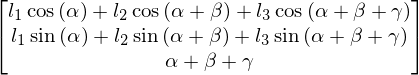

In [4]:
P = Matrix([x, y, theta])
P

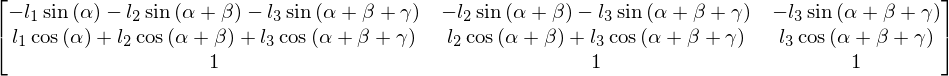

In [5]:
J = P.jacobian([alpha, beta, gamma])
J

In [6]:
# Convert the Jacobian to a numerical version
Jnum = lambdify((alpha, beta, gamma, l1, l2, l3), J, 'numpy')

In [7]:
# Evaluate the jacobian around singularity, in normal working regime and define a force vector
Jnormal = Jnum(0.230, -0.2, 0.2, 86, 72, 55)
Jsingular = Jnum(1e-3, 1e-3, 0, 86, 72, 55)
F = np.array([1, 0, 0])

# Jacobian Inverse method

According to Buss (2009) this sucks big times

In [8]:
JI = lambda J, F: np.linalg.inv(J) @ F

In [9]:
JI(Jnormal, F)

array([-0.05850261,  0.12657122, -0.06806861])

In [10]:
JI(Jsingular, F)

array([ 11.62788566, -25.51676992,  13.88888426])

In [11]:
# Here is why it is a problem: the condition number of the matrix gets huge around the singularity:
print(np.linalg.cond(Jnormal))
print(np.linalg.cond(Jsingular))

341.023799704
7956.88862393


# Dampled least square

This should be a bit better around oscillations

In [12]:
DLS_damp = lambda J, F, damping: J.T @ np.linalg.inv((J @ J.T + damping ** 2 * np.eye(3))) @ F

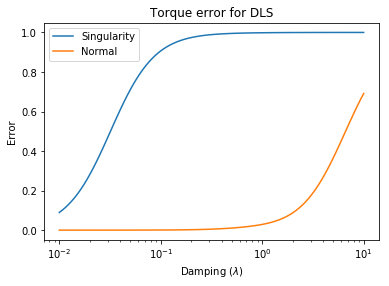

In [13]:
Damping = np.logspace(-2, 1, num=100)
err_sing = lambda l: np.linalg.norm(Jsingular @ DLS_damp(Jsingular, F, l) - F)
err_norm = lambda l: np.linalg.norm(Jnormal @ DLS_damp(Jnormal, F, l) - F)

plt.semilogx(Damping, np.array([err_sing(s) for s in Damping]))
plt.semilogx(Damping, np.array([err_norm(s) for s in Damping]))
plt.legend(['Singularity', 'Normal'])
plt.xlabel('Damping ($\lambda$)')
plt.ylabel('Error')
plt.title('Torque error for DLS')

# Comparison of results

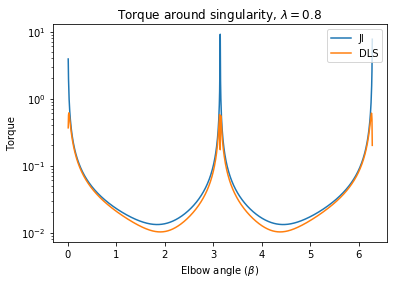

In [16]:
damping = 0.8
DLS = lambda J, F: J.T @ np.linalg.inv((J @ J.T + damping ** 2 * np.eye(3))) @ F
Beta = np.linspace(0.00, 2 * 3.14, num=1000)

def JI_safe(J, F):
    try:
        return JI(J, F)
    except:
        return float('nan')
    
torque_JI = lambda beta: np.linalg.norm(JI_safe(Jnum(0, beta, 0, 100, 100, 0), F))
torque_JI = np.vectorize(torque_JI)

torque_DLS = lambda beta: np.linalg.norm(DLS(Jnum(0, beta, 0, 100, 100, 0), F))
torque_DLS = np.vectorize(torque_DLS)

plt.semilogy(Beta, np.array([torque_JI(b) for b in Beta]))
plt.semilogy(Beta, np.array([torque_DLS(b) for b in Beta]))

plt.legend(('JI', 'DLS'))
plt.xlabel('Elbow angle ($\\beta$)')
plt.ylabel('Torque')
#plt.ylim(-0.1, 1)
plt.title('Torque around singularity, $\\lambda = {:.1f}$'.format(damping))

# Useful numerical values for testing

In [19]:
DLS_damp(Jnum(0.2, -0.2, 0., 100, 200, 30), np.array([1, 1, 0]), 0.8)

array([-0.05005812,  0.07721903, -0.01137551])

In [22]:
DLS_damp(Jnum(0.2e-3, -0.2e-3, 0., 100, 200, 30), np.array([1, 1, 0]), 0.8)

array([-0.007023  ,  0.01490902, -0.00371818])

# References
Buss, S. R. Introduction to inverse kinematics with jacobian transpose, pseudoinverse and damped least squares methods, 2009. Typeset manuscript from: http://math.ucsd.edu/~sbuss/ResearchWeb.